# Spark Healthcare Analysis

## Objective:
- The objective from this project is to create a <b>Logistic Regression Classifier</b> to predict the <b>Stroke Condition</b>.
- <b>Stoke</b> is a condition in which either the blood flow to the brain stops or blood flow is excessive.
- It is required to obtain <b>ROC > 0.65</b>.

### Data:
- Data is provided in csv format in a file named <b>healthcare-dataset-stroke-data.csv</b>

### Column names and data types are as follow:
- id, integer.
- gender, string.
- age, double.
- hypertension, integer.
- heart_disease, integer.
- ever_married, string.
- work_type, string.
- Residence_type, string.
- avg_glucose_level, double.
- bmi, double.
- smoking_status, string.
- stroke, integer <b>(Target Label)</b>.
If the person has stroke the stroke label value is <b>"1"</b> otherwise <b>"0"</b>.

## To perform this task follow the following guiding steps:

### Create a spark session and import the required libraries

In [39]:
# 1. install all the dependencies in Colab environment i.e. Apache Spark 3.0.1 with hadoop 2.7, Java 8 and Findspark to locate the spark in the system
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark-dist-explore

# 2. Setup Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"


### Create a data schema programatically

In [2]:
# 3. Start Spark Session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

### Read the data using the standard DataReader (Key,Value) pairs format
- Provide the schema and any other required options.

In [537]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType

# id, integer.
# gender, string.
# age, double.
# hypertension, integer.
# heart_disease, integer.
# ever_married, string.
# work_type, string.
# Residence_type, string.
# avg_glucose_level, double.
# bmi, double.
# smoking_status, string.

schema = StructType([StructField("id", IntegerType(), False),
                     StructField("gender", StringType(), False),
                                StructField("age", DoubleType(), False),
                                StructField("hypertension", IntegerType(), False),
                                StructField("heart_disease", IntegerType(), False),
                                StructField("ever_married", StringType(), False),
                                StructField("work_type", StringType(), False),
                                StructField("Residence_type", StringType(), False),
                                StructField("avg_glucose_level", DoubleType(), False),
                                StructField("bmi", DoubleType(), False),
                                StructField("smoking_status", StringType(), False),
                                  StructField("stroke", IntegerType(), False)])




df = spark.read.csv("healthcare-dataset-stroke-data.csv", header = True, schema= schema)

### Explore the data 
#### You have to do the following:
- Print the Schema.
- Show the first 10 rows from the data.
- Explore null values and show how many null values in each column.
- Plot a count plot for the target label and <b>notice the graph</b>.
- Perform any additional EDA you find useful.

In [538]:
print(df.printSchema())

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)

None


In [539]:
df.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|null|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [540]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



(array([4861.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         249.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

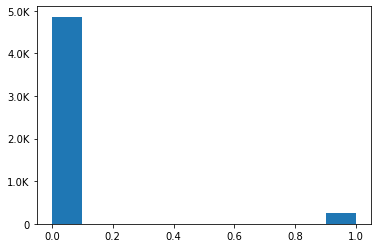

In [541]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import pandas as pd 



fig, ax = plt.subplots()
hist(ax, df.select('stroke'))



### Get the summary statistics of the age column
- You will find the minimum age is about <b>0.08</b>.
- Remove rows for the age below <b>2 years old</b>.

In [542]:
df.select("age").summary().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    25%|              25.0|
|    50%|              45.0|
|    75%|              61.0|
|    max|              82.0|
+-------+------------------+



In [543]:
df = df.filter(df.age > 2)

In [544]:
df.select("age").summary().show()

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|             4935|
|   mean|44.70982776089159|
| stddev|21.56859737335159|
|    min|              3.0|
|    25%|             27.0|
|    50%|             46.0|
|    75%|             61.0|
|    max|             82.0|
+-------+-----------------+



### Working with gender & smoking_status columns:
- Select and show the gender & smoking_status columns
- Get the distinct values for each column.

In [545]:
df.select("gender", "smoking_status").show()

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [546]:
df.select("gender").distinct().show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [547]:
df.select("smoking_status").distinct().show()

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



#### Change the string values of the columns into numerical values as follow:
1. Gender column:
    * Male = 1 
    * Female = 0 
    * Other = 0 
2. Smoking Status column:
  * never smoked = 0
  * Unknown = 0.5
  * formerly smoked = 0.75
  * smokes = 1.0


In [548]:
from pyspark.sql.functions import udf, avg


def replace_val(val):
    if val == "Unknown":
        return 0.5
    elif val == "never smoked":
        return 0.0
    elif val == 'formerly smoked':
        return 0.75
    elif val == "smokes": 
        return 1.0

def replace_gen(val):
    if val == "Male":
        return 1
    elif val == "Female":
        return 0
    elif val == 'Other':
        return 0
    else: 
        return 1

rval = udf(lambda z: replace_val(z),DoubleType())

rgen = udf(lambda z: replace_gen(z),IntegerType())



In [549]:
df = df.withColumn("smoking_status", rval(col("smoking_status")))
df.show()


+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|          0.75|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|null|           0.0|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|           0.0|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|           1.0|     1|
| 1665|Female|79.0|           1|            0|         Yes|Sel

In [550]:
df = df.withColumn("gender", rgen(col("gender")))
df.show()



+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
| 9046|     1|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|          0.75|     1|
|51676|     0|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|null|           0.0|     1|
|31112|     1|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|           0.0|     1|
|60182|     0|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|           1.0|     1|
| 1665|     0|79.0|           1|            0|         Yes|Sel

#### Show the output DataFrame
- Select and show the gender & smoking_status columns after value changing.
- Print schema for the new dataframe.

In [551]:
df.select("gender", "smoking_status").show()

+------+--------------+
|gender|smoking_status|
+------+--------------+
|     1|          0.75|
|     0|           0.0|
|     1|           0.0|
|     0|           1.0|
|     0|           0.0|
|     1|          0.75|
|     1|           0.0|
|     0|           0.0|
|     0|           0.5|
|     0|           0.5|
|     0|           0.0|
|     0|           1.0|
|     0|           1.0|
|     1|           0.5|
|     0|           0.0|
|     0|           0.0|
|     1|           1.0|
|     1|           1.0|
|     0|           0.0|
|     1|           0.5|
+------+--------------+
only showing top 20 rows



In [552]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)



### Deal with null value according to your data analysis.

In [553]:
val = df.select(avg('bmi')).collect()[0][0]
df = df.na.fill(val, subset=['bmi'])

In [554]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



### Split the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.
- Save each dataframe as a parquet file

In [555]:
train, test = df.randomSplit([0.8, 0.2], seed = 42)

In [556]:
ct = train.count()
cts = test.count()

print(ct / cts)

4.227754237288136


In [557]:
train.write.format("parquet").mode("overwrite").save("train.parquet")
test.write.format("parquet").mode("overwrite").save("test.parquet")

### Read the saved Train and Test DataFrame:
- Use the dataframes you read in the subsequent steps.

In [558]:
train = spark.read.parquet("train.parquet")
test = spark.read.parquet("test.parquet")


In [559]:
train.show()

+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+--------------+------+
| id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|               bmi|smoking_status|stroke|
+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+--------------+------+
| 67|     0|17.0|           0|            0|          No|      Private|         Urban|            92.97|29.257489451476793|          0.75|     0|
| 77|     0|13.0|           0|            0|          No|     children|         Rural|            85.81|              18.6|           0.5|     0|
| 91|     0|42.0|           0|            0|          No|      Private|         Urban|            98.53|              18.5|           0.0|     0|
| 99|     0|31.0|           0|            0|          No|      Private|         Urban|           108.89|              52.3| 

In [560]:
categoricalCols = [field for (field, dataType) in train.dtypes
                   if dataType == "string"]

categoricalCols

['ever_married', 'work_type', 'Residence_type']

In [561]:
indexOutputCols = [x + "_Index" for x in categoricalCols]
indexOutputCols



['ever_married_Index', 'work_type_Index', 'Residence_type_Index']

In [562]:
stringIndexer = StringIndexer(inputCols=categoricalCols,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

In [563]:
oheOutputCols = [x + "_OHE" for x in categoricalCols]
oheOutputCols

['ever_married_OHE', 'work_type_OHE', 'Residence_type_OHE']

In [564]:
numericCols = [field for (field,dataType) in train.dtypes
              if ((dataType=='double')& (field!='stroke'))]
numericCols

['age', 'avg_glucose_level', 'bmi', 'smoking_status']

In [565]:
assemblerInputs = oheOutputCols + numericCols
assemblerInputs

['ever_married_OHE',
 'work_type_OHE',
 'Residence_type_OHE',
 'age',
 'avg_glucose_level',
 'bmi',
 'smoking_status']

In [566]:
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')

### Create the model:
- Perform feature engineering steps.
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

In [567]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='stroke',featuresCol='features')
pipeline =Pipeline(stages = [stringIndexer,oheEncoder,vecAssembler,lr])


In [568]:
pipelineModel = pipeline.fit(train)

In [569]:
predDF = pipelineModel.transform(test)

### Perform predictions on tests dataframe:
- Test the model using the test dataframe
- Select and show the feature column.
- Print the schema of the output dataframe.
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   

In [570]:
predDF.select("stroke").groupBy("stroke").count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|   39|
|     0|  905|
+------+-----+



### Evaluate the model performance
- Use <b>BinaryClassificationEvaluator</b>. This will calculate the <b>ROC</b>.
- Set the parameters as follow:
    - <b>rawPredictionCol='prediction'</b> and <b>labelCol='stroke'</b>

In [571]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [572]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [573]:
evaluatorROC.evaluate(predDF)

0.4994475138121547

### Improve Model Performance
- You may noticed that <b>the target label is imbalanced</b>.
- LogisticRegression classifier has a special parameter <b>weightCol</b> to deal with imbalanced class.
- In order to use this parameter you must have a <b>weightCol</b> in your training dataframe.
- In order to create this column you will need to define a <b>UDF</b> and apply it to the target label column.
- Create a LogisticRegression classifier with <b>weightCol</b> parameter.
- Build and train a pipeline model with the new LogisticRegression.
- Perform the prediction on the test dataframe. 
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   
- Evaluate the model performance exactly as in the previous step.
### YOU SHOULD OBTAIN  ROC > 0.65
<BR>
<b><font color='red'>Note: feel free to deal with the imbalanced cluster with the above method or another. However, you can only use methods applied on SPARK DATAFRAME</font></b>

In [574]:
w0 = train.select("stroke").groupBy("stroke").count().collect()[0][0]
w1 = train.select("stroke").groupBy("stroke").count().collect()[0][1]

def ss(val):
    if val == 0:
        return w0 / w1
    elif val == 1:
        return 1.0
   

ff = udf(lambda z: ss(z),DoubleType())

train = train.withColumn("ww", ff(col("stroke")))


In [575]:
train.show()

+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+--------------+------+--------------------+
| id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|               bmi|smoking_status|stroke|                  ww|
+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+--------------+------+--------------------+
| 67|     0|17.0|           0|            0|          No|      Private|         Urban|            92.97|29.257489451476793|          0.75|     0|0.004784688995215311|
| 77|     0|13.0|           0|            0|          No|     children|         Rural|            85.81|              18.6|           0.5|     0|0.004784688995215311|
| 91|     0|42.0|           0|            0|          No|      Private|         Urban|            98.53|              18.5|           0.0|     0|0.004784688995215311

In [576]:
lr = LogisticRegression(labelCol='stroke',featuresCol='features', weightCol= "ww")
pipeline =Pipeline(stages = [stringIndexer,oheEncoder,vecAssembler,lr])

pipelineModel = pipeline.fit(train)
pred_W = pipelineModel.transform(test)

In [577]:
evaluatorROC.evaluate(pred_W)

0.6694999291684374